In [1]:
#!pip install neurox
#!pip install torch

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
sys.path.append('../src')
from data_classes import get_file_names, ConvertSample, GetEmbeddings
from probing_classes import get_converted_filenames, Experiment, Trainer

## Что это за проект

#### По сути -- это конвейер, который использует методы библиотеки NeuroX для пробинга по нейронам и слоям

1. Сначала вы должны использовать AIRI Probing framework (https://github.com/AIRI-Institute/Probing_framework), то есть подать туда conllu файлы, затем положить полученные .csv файлы в папку проекта (f'project/data/data_{language}_{dataset}')
2. Ниже приведен код, который для всех файлов создает balanced-выборку для трейна и теста, получает эмбеддинги для предложений. Вы можете получить true данные, а также данные для Control Task с перепутанными лейблами грамматических категорий.
3. Затем вы должны создать экземляр класса Trainer. Вы должны создавать новый экземляр каждый раз, когда меняете данные, которые туда подаете, а также флаг ablation (для зануления части нейронов).
4. Что умеет делать Trainer (его методы):

    Он умеет работать с одной и многими грамматическими категориями.
* train_classification() -- обычная пробинг-классификация (log reg). Scores лежат в аттрибуте scores (сохраните в отдельную переменную)
* train_classification(n=5, goal='ranking') -- записывает в словарь ранжированные нейроны. Если n=5, запишет для каждой категории по 5 top-нейронов. Они лежат в аттрибуте ordered_neurons.
* train_classification(n=5, goal='keep_ablation') -- пробинг на топ-n нейронах. Scores лежат в аттрибуте ablation_scores (сохраните в отдельную переменную)
* train_classification(i=9884, goal='remove_ablation') -- пробинг на bottom-n нейронах. Удаляет i нейронов. Scores лежат в аттрибуте ablation_scores (сохраните в отдельную переменную)
* train_layers -- учится на всех слоях по очереди. Scores лежат в аттрибуте scores (сохраните в отдельную переменную)

Данные для пробинга + Control Task -- лейблы перемешаны

In [4]:
data_path = f'{str(Path(os.getcwd()).parents[0])}/data/data_en_gum' #тут пишется руками dataset name (где лежат .csv файлы)

In [5]:
for file in sorted(get_file_names(data_path)): 
    
    splitter = ConvertSample(file, train_size=1500, test_size=500)
    
    #получаем трейн и тест выборку
    path_trdata, path_trlabel, path_ctrdata, path_ctrlabel, path_tedata, path_telabel = splitter.writer()
    
    #получаем эмбеддинги (долго)
    data = GetEmbeddings(path_trdata, path_tedata)
    data.jsons('bert-base-uncased') # можно выбрать другой трансформер из HF
    clear_output(wait=False)

In [6]:
large_data_path = f'{str(Path(os.getcwd()).parents[0])}/data/large_data_en_gum' #тут пишется руками dataset name 
true_paths, control_paths  = get_converted_filenames(large_data_path)

In [7]:
print(f'Вот столько у нас категорий для датасета en_gum: {len(true_paths)}')

Вот столько у нас категорий для датасета en_gum: 12


In [8]:
true_paths[0]

['/home/senya/Документы/project/data/large_data_en_gum/data_Number/datatrain_Number.txt',
 '/home/senya/Документы/project/data/large_data_en_gum/data_Number/labeltrain_Number.txt',
 '/home/senya/Документы/project/data/large_data_en_gum/data_Number/datatest_Number.txt',
 '/home/senya/Документы/project/data/large_data_en_gum/data_Number/labeltest_Number.txt']

In [9]:
control_paths[0]

['/home/senya/Документы/project/data/large_data_en_gum/data_Number/cdatatrain_Number.txt',
 '/home/senya/Документы/project/data/large_data_en_gum/data_Number/clabeltrain_Number.txt',
 '/home/senya/Документы/project/data/large_data_en_gum/data_Number/datatest_Number.txt',
 '/home/senya/Документы/project/data/large_data_en_gum/data_Number/labeltest_Number.txt']

### Создаем экземпляр класса для одной категории и вызываем методы

In [10]:
train_one = Trainer(true_paths[0])
train_one.train_classification()

Loading json activations from /home/senya/Документы/project/data/large_data_en_gum/data_Number/activations_train.json...
1500 13.0
Loading json activations from /home/senya/Документы/project/data/large_data_en_gum/data_Number/activations_te.json...
500 13.0
Number of tokens:  1500
length of source dictionary:  5756
length of target dictionary:  2
1500
Total instances: 1500
['Agents', 'Doctor', 'Numbered', 'Very', 'Extracts', 'Betty', 'Ideally', 'Thank', 'Listing', 'Nice', 'Air', 'Unfortunately', 'Vagabond', 'Beaters', 'Smack', 'Hold', 'Infected', 'Braised', 'Keep', '"And']
Number of samples:  1500
Stats: Labels with their frequencies in the final set
Plur 750
Sing 750
Number of tokens:  500
length of source dictionary:  2550
length of target dictionary:  2
500
Total instances: 500
['Things', 'sexual', 'I', 'psychologists', 'if', 'There', 'Just', '"Among', 'Compared', 'Most', 'Move', 'White', 'As', 'Too', 'Voters', 'Other', 'Anyways', 'Yep', 'Norton', 'height']
Number of samples:  500
S

epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0263


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0135


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0109


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0098


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0091


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0087


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0084


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0081


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0079


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0078


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.97


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.80
train_classification took 43.0523 secs


In [11]:
scores = train_one.scores.copy()

In [12]:
scores

{'Number': [{'__OVERALL__': 0.9733333333333334,
   'Plur': 0.9906666666666667,
   'Sing': 0.956},
  {'__OVERALL__': 0.796, 'Plur': 0.868, 'Sing': 0.724}]}

In [13]:
train_one.train_classification(n=5, goal='ranking') 
ordered_neurons = train_one.ordered_neurons.copy()
clear_output(wait=False)

In [14]:
ordered_neurons

{'Number': [9699, 9124, 7932, 3367, 4135]}

### Пробинг на 5-ом (6 слое) 

In [15]:
train_one.train_layers(n=5)
scores_layer = train_one.scores.copy()
clear_output(wait=False)

In [16]:
scores_layer

{('Number',
  5): [{'__OVERALL__': 0.8886666666666667,
   'Plur': 0.8933333333333333,
   'Sing': 0.884}, {'__OVERALL__': 0.81, 'Plur': 0.86, 'Sing': 0.76}]}

### Пробинг от 0 до 5 слоя

In [17]:
train_one.train_layers(lrange=6)
scores_layers = train_one.scores.copy()
clear_output(wait=False)

In [18]:
def plot_layerwise(d):
    layers = [k[1] for k in d.keys()]
    accuracy_train=[round(v[0]['__OVERALL__'], 2) for k, v in d.items()]
    accuracy_test = [round(v[1]['__OVERALL__'], 2) for k, v in d.items()]
    index = layers
    df = pd.DataFrame({'train_acc': accuracy_train,
                        'test_acc': accuracy_test}, index=index)
    ax = df.plot.bar(rot=0, color={"train_acc": "green", "test_acc": "red"})

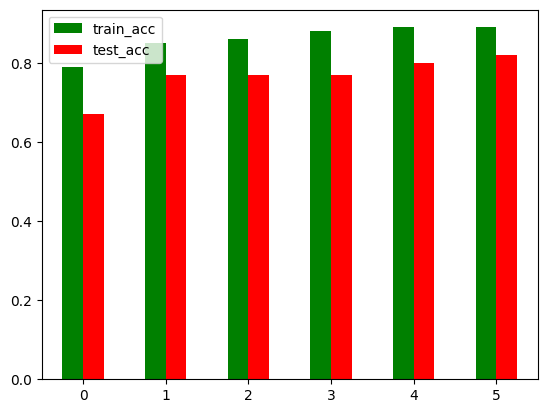

In [19]:
plot_layerwise(scores_layers)

### Создаем экземпляр класса для одной категории и подаем данные для contol task

In [20]:
train_control = Trainer(control_paths[0]) 
train_control.train_classification()
clear_output(wait=False)

In [21]:
control_scores = train_control.scores.copy()

In [22]:
def bad_scores(scores):
    m = []
    for k, v in scores.items():
        m.append(v[1]['__OVERALL__'])
    return np.array(m)

In [23]:
selectivity = bad_scores(scores) - bad_scores(control_scores)
print('Selectivity (Diff. between true task and control task performance): ', selectivity)

Selectivity (Diff. between true task and control task performance):  [0.29]


### Создаем экземпляр класса для многих категорий

### Пробинг на true данных

In [24]:
train_all = Trainer(true_paths[1:6])
train_all.train_classification()
all_scores = train_all.scores.copy()
clear_output(wait=False)

In [25]:
def accuracy_plot(dct_acc):
    cats=[k for k in dct_acc.keys()]
    accuracy_train=[round(v[0]['__OVERALL__'], 2) for k, v in dct_acc.items()]
    accuracy_test = [round(v[1]['__OVERALL__'], 2) for k, v in dct_acc.items()]
    index = cats
    df = pd.DataFrame({'train_acc': accuracy_train,
                        'test_acc': accuracy_test}, index=index)
    ax = df.plot.bar(rot=0, color={"train_acc": "green", "test_acc": "red"})

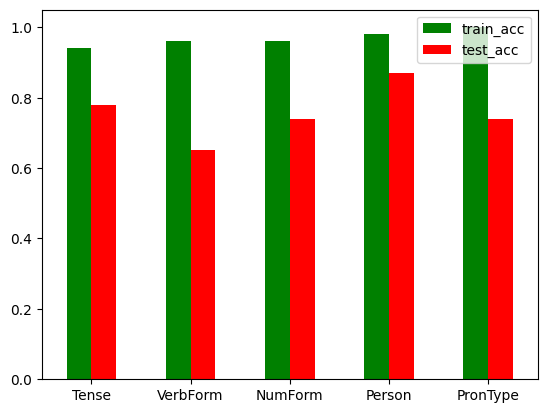

In [26]:
accuracy_plot(all_scores)

### Пробинг на control task данных

In [27]:
train_all_control = Trainer(control_paths[1:6])
train_all_control.train_classification()
all_scores_control = train_all_control.scores.copy()
clear_output(wait=False)

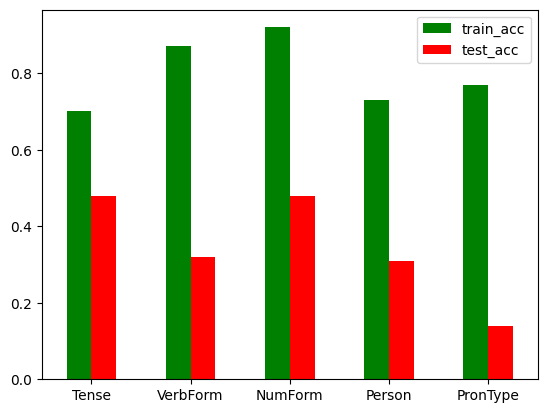

In [28]:
accuracy_plot(all_scores_control)

In [29]:
selectivity = bad_scores(all_scores) - bad_scores(all_scores_control)
print('Selectivity (Diff. between true task and control task performance): ', selectivity)

Selectivity (Diff. between true task and control task performance):  [0.3        0.33497537 0.26366559 0.56487026 0.5942029 ]


### Создаем экземпляр класса и меняем флаг ablation

### Оставляем топ-n нейронов (100 по умолчанию)

In [30]:
train_ablation = Trainer(true_paths[6:11], ablation=True)
train_ablation.train_classification(n=200, goal='keep_ablation') #оставим топ-200 нейронов
clear_output(wait=False)

In [31]:
scores_before = train_ablation.scores.copy() #accuracy до зануления нейронов

In [32]:
keep_scores = train_ablation.ablation_top_scores.copy() #accuracy на топ-n нейронах
keep_neurons = train_ablation.ordered_neurons.copy()

In [33]:
print(len(keep_neurons['Mood'])) # проверим что их было по 200, как мы поставили

200


In [34]:
keep_neurons['Mood'][:5]

[8957, 7693, 8896, 8999, 8461]

### Оставляем bottom-n нейронов (100 по умолчанию)

In [35]:
train_ablation.train_classification(i=9774, goal='remove_ablation')
clear_output(wait=False)

In [36]:
remove_scores = train_ablation.ablation_bottom_scores.copy()
remove_neurons_except = train_ablation.ordered_neurons.copy()

In [37]:
print(len(remove_neurons_except['Mood']))

210


In [38]:
remove_neurons_except['Mood'][:5]

[6726, 6734, 6735, 6738, 6744]

### Графики

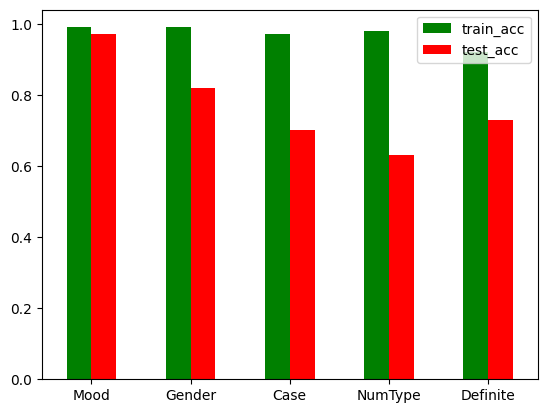

In [39]:
accuracy_plot(scores_before) # до зануления

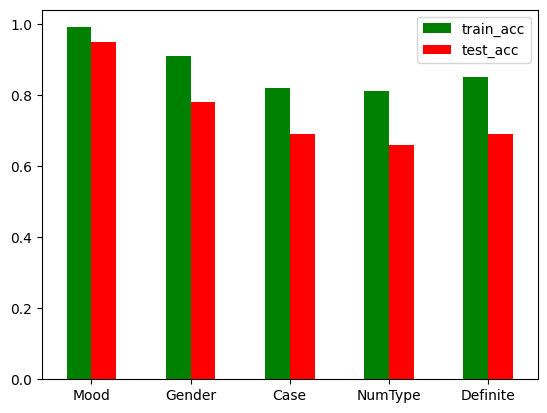

In [40]:
accuracy_plot(keep_scores) # на топ-200 нейронах

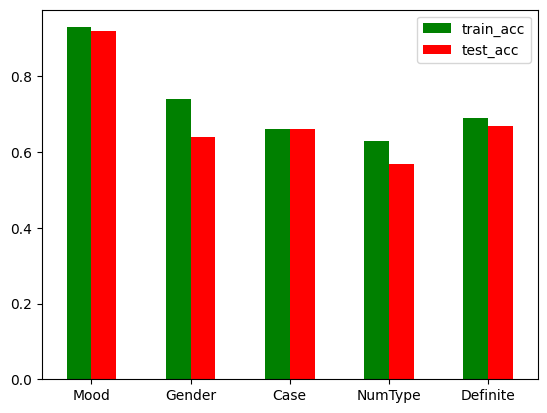

In [41]:
accuracy_plot(remove_scores) # на bottom-200 нейронах